### Imports ###

In [1]:
import gc
import os
import random
import re
import warnings
from collections import Counter
from typing import List

import lightgbm as lgb
import lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pl.__version__

'2.1.0'

### Hyperparameters + Config

In [3]:
class Config:
    """
    > General Options
    """

    # global seed
    seed = 42
    # max rows to display for pandas dataframes
    display_max_rows = 100
    # name of the response variate we are trying to predict
    response_variate = "score"

    max_timeseries_length = 5000  # Maximum length that model can take.

    experiment_name = "LSTM"

    """
    > Preprocessing Options
    """
    # number of folds to split the data for CV
    num_folds = 5

    """
    > Modelling Options
    """
    # whether to use optuna tuning or not
    # if False, then we load in pretuned weights for the LGBM models
    use_optuna_tuning = True
    # size of the test set for optuna tuning
    # if use_optuna_tuning=True
    test_size_optuna = 0.2
    num_trials_optuna = 80
    early_stopping_rounds = 30

    """
    > Post-Modelling Options
    """
    # number of most important features to display
    # for the feature importances plot
    num_features_to_display = 50

    # Data Paths
    base_dir_path = f"data/"

    train_logs = f"{base_dir_path}train_logs.csv"
    train_scores = f"{base_dir_path}train_scores.csv"
    test_logs = f"{base_dir_path}test_logs.csv"

    # Training checkpoint path
    training_logs_path = f"./training_logs"

In [4]:
CONFIG = Config()

In [5]:
tqdm.pandas()
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", CONFIG.display_max_rows)
warnings.simplefilter("ignore")

random.seed(CONFIG.seed)

### Load Data

In [6]:
train_logs = pd.read_csv(CONFIG.train_logs)
train_scores = pd.read_csv(CONFIG.train_scores)
test_logs = pd.read_csv(CONFIG.test_logs)

In [7]:
test_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0


In [8]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


### Utility

In [9]:
def plot_all_timeseries_events(sample):
    clms = [
        "down_time",
        "up_time",
        "action_time",
        "activity",
        "down_event",
        "up_event",
        # "text_change",
        "cursor_position",
        "word_count",
    ]
    num_clms = len(clms)
    # define subplot grid
    fig, axs = plt.subplots(nrows=(num_clms // 3) + 1, ncols=3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(f"{sample.id}", fontsize=18, y=0.95)

    # loop through tickers and axes
    for clm, ax in zip(clms, axs.ravel()):
        ax.plot(range(CONFIG.max_timeseries_length), sample[clm])
        # chart formatting
        ax.set_title(clm)
        #     ax.get_legend().remove()
        ax.set_xlabel("event_id")

    plt.show()

### Pre Processing ###

In [10]:
class Preprocessor:
    def __init__(self, seed):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
            "Control",
            '"',
            "-",
            "?",
            ";",
            "=",
            "Tab",
            "/",
            "Rightclick",
            ":",
            "(",
            ")",
            "\\",
            "ContextMenu",
            "End",
            "!",
            "Meta",
            "Alt",
            "[",
            "c",
            "v",
            "NumLock",
            "Insert",
            "Home",
            "z",
            "AudioVolumeDown",
            "F2",
            "a",
            "x",
            "AudioVolumeUp",
            "$",
            ">",
            "]",
            "*",
            "%",
            "&",
            "Dead",
            "s",
            "Escape",
            "ModeChange",
            "F3",
            "<",
            "AudioVolumeMute",
            "F15",
            "+",
            "ScrollLock",
            "Process",
            "PageDown",
            "t",
            "i",
            "_",
            "{",
            "PageUp",
            "`",
            "0",
            "#",
            "1",
            "Middleclick",
            "5",
            "F12",
            "Unidentified",
        ]
        self.text_changes = [
            "q",
            " ",
            "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
            "__OTHER__",
        ]
        self.punctuations = [
            '"',
            ".",
            ",",
            "'",
            "-",
            ";",
            ":",
            "?",
            "!",
            "<",
            ">",
            "/",
            "@",
            "#",
            "$",
            "%",
            "^",
            "&",
            "*",
            "(",
            ")",
            "_",
            "+",
        ]

    def activity_counts(self, df):
        tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["activity"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{i}_count" for i in ret.columns]
        ret.columns = cols
        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby("id").agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
                else:
                    di["Unidentified"] += v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"{colname}_{i}_count" for i in ret.columns]
        ret.columns = cols
        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["text_change"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
                else:
                    di["__OTHER__"] += v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"text_change_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["down_event"].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({"punct_cnt": ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_length_mean"] = tmp_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_max"] = tmp_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_std"] = tmp_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df.drop(["text_change"], axis=1, inplace=True)
        return tmp_df

    def make_feats(self, df):
        print("Starting to engineer features")

        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})

        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            ("action_time", ["sum", "max", "mean", "std"]),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "mean"]),
            ("word_count", ["nunique", "max", "mean"]),
        ]

        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = (
                    df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                feats = feats.merge(tmp_df, on="id", how="left")

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering event counts data")
        tmp_df = self.event_counts(df, "down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, "up_event")
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # input words
        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on="id", how="left")

        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]

        print("Done!")
        return feats

In [11]:
preprocessor = Preprocessor(seed=CONFIG.seed)

print("-" * 25)
print("Engineering features for training data")
print("-" * 25)
train_feats = preprocessor.make_feats(train_logs)

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
test_feats = preprocessor.make_feats(test_logs)

-------------------------
Engineering features for training data
-------------------------
Starting to engineer features
Engineering statistical summaries for features


100%|█████████████| 9/9 [00:08<00:00,  1.10it/s, column=word_count, method=mean]


Engineering activity counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 11649.12it/s]


Engineering event counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 11348.41it/s]


Engineering text change counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 10517.78it/s]


Engineering punctuation counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 10914.11it/s]


Engineering input words data
Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Starting to engineer features
Engineering statistical summaries for features


100%|████████████| 9/9 [00:00<00:00, 138.14it/s, column=word_count, method=mean]


Engineering activity counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 65196.44it/s]


Engineering event counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 58525.17it/s]


Engineering text change counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 72315.59it/s]


Engineering punctuation counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 64860.37it/s]

Engineering input words data
Engineering ratios data
Done!


In [12]:
train_feats

,id,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,activity_Input_count,activity_Remove/Cut_count,activity_Nonproduction_count,activity_Replace_count,activity_Paste_count,down_event_q_count,down_event_Space_count,down_event_Backspace_count,down_event_Shift_count,down_event_ArrowRight_count,down_event_Leftclick_count,down_event_ArrowLeft_count,down_event_._count,"down_event_,_count",down_event_ArrowDown_count,down_event_ArrowUp_count,down_event_Enter_count,down_event_CapsLock_count,down_event_'_count,down_event_Delete_count,down_event_Unidentified_count,down_event_Control_count,"down_event_""_count",down_event_-_count,down_event_?_count,down_event_;_count,down_event_=_count,down_event_Tab_count,down_event_/_count,down_event_Rightclick_count,down_event_:_count,down_event_(_count,down_event_)_count,down_event_\_count,down_event_ContextMenu_count,down_event_End_count,down_event_!_count,down_event_Meta_count,down_event_Alt_count,down_event_[_count,down_event_c_count,down_event_v_count,down_event_NumLock_count,down_event_Insert_count,down_event_Home_count,down_event_z_count,down_event_AudioVolumeDown_count,down_event_F2_count,down_event_a_count,down_event_x_count,down_event_AudioVolumeUp_count,down_event_$_count,down_event_>_count,down_event_]_count,down_event_*_count,down_event_%_count,down_event_&_count,down_event_Dead_count,down_event_s_count,down_event_Escape_count,down_event_ModeChange_count,down_event_F3_count,down_event_<_count,down_event_AudioVolumeMute_count,down_event_F15_count,down_event_+_count,down_event_ScrollLock_count,down_event_Process_count,down_event_PageDown_count,down_event_t_count,down_event_i_count,down_event___count,down_event_{_count,down_event_PageUp_count,down_event_`_count,down_event_0_count,down_event_#_count,down_event_1_count,down_event_Middleclick_count,down_event_5_count,down_event_F12_count,up_event_q_count,up_event_Space_count,up_event_Backspace_count,up_event_Shift_count,up_event_ArrowRight_count,up_event_Leftclick_count,up_event_ArrowLeft_count,up_event_._count,"up_event_,_count",up_event_ArrowDown_count,up_event_ArrowUp_count,up_event_Enter_count,up_event_CapsLock_count,up_event_'_count,up_event_Delete_count,up_event_Unidentified_count,up_event_Control_count,"up_event_""_count",up_event_-_count,up_event_?_count,up_event_;_count,up_event_=_count,up_event_Tab_count,up_event_/_count,up_event_Rightclick_count,up_event_:_count,up_event_(_count,up_event_)_count,up_event_\_count,up_event_ContextMenu_count,up_event_End_count,up_event_!_count,up_event_Meta_count,up_event_Alt_count,up_event_[_count,up_event_c_count,up_event_v_count,up_event_NumLock_count,up_event_Insert_count,up_event_Home_count,up_event_z_count,up_event_AudioVolumeDown_count,up_event_F2_count,up_event_a_count,up_event_x_count,up_event_AudioVolumeUp_count,up_event_$_count,up_event_>_count,up_event_]_count,up_event_*_count,up_event_%_count,up_event_&_count,up_event_Dead_count,up_event_s_count,up_event_Escape_count,up_event_ModeChange_count,up_event_F3_count,up_event_<_count,up_event_AudioVolumeMute_count,up_event_F15_count,up_event_+_count,up_event_ScrollLock_count,up_event_Process_count,up_event_PageDown_count,up_event_t_count,up_event_i_count,up_event___count,up_event_{_count,up_event_PageUp_count,up_event_`_count,up_event_0_count,up_event_#_count,up_event_1_count,up_event_Middleclick_count,up_event_5_count,up_event_F12_count,text_change_0_count,text_change_1_count,text_change_2_count,text_change_3_count,text_change_4_count,text_change_5_count,text_change_6_count,text_change_7_count,text_change_8_count,text_change_9_count,text_change_10_count,text_change_11_count,text_change_12_count,text_change_13_count,text_change_14_count,text_change_15_count,punct_cnt,input_word_count,input_word_length_mean,input_word_lengt

In [13]:
def make_seq_max_length_seq(seq, max_length, value_to_add):
    if len(seq) < max_length:
        to_add_seq = [value_to_add] * (max_length - len(seq))
        new_seq = seq + to_add_seq
    else:
        new_seq = seq[:max_length]
    return new_seq

In [14]:
def get_grouped_df(
    exploded_df: pd.DataFrame, grp_by_clms: List[str] = ["id"]
) -> pd.DataFrame:
    grpd_df = exploded_df.groupby(grp_by_clms, as_index=False).agg(
        lambda x: list(x),
    )
    grpd_df["num_events"] = grpd_df.apply(lambda x: len(x.event_id), axis=1)

    values_to_add = {
        "down_time": -1,
        "up_time": -1,
        "action_time": -1,
        "activity": "__NoActivity",
        "down_event": "__NoEvent",
        "up_event": "__NoEvent",
        # "text_change",
        "cursor_position": -1,
        "word_count": -1,
    }

    for clm in values_to_add.keys():
        grpd_df[clm] = grpd_df[clm].apply(
            lambda x: make_seq_max_length_seq(
                x, CONFIG.max_timeseries_length, values_to_add[clm]
            )
        )

    return grpd_df

In [15]:
train_grpd_df = get_grouped_df(train_logs)
# Add scores
train_grpd_df = train_grpd_df.merge(train_scores, on="id").merge(train_feats, on="id")

In [16]:
train_grpd_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,num_events,score,event_id_max,up_time_max,action_time_sum,action_time_max,action_time_mean,action_time_std,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_max,cursor_position_mean,word_count_nunique,word_count_max,word_count_mean,activity_Input_count,activity_Remove/Cut_count,activity_Nonproduction_count,activity_Replace_count,activity_Paste_count,down_event_q_count,down_event_Space_count,down_event_Backspace_count,down_event_Shift_count,down_event_ArrowRight_count,down_event_Leftclick_count,down_event_ArrowLeft_count,down_event_._count,"down_event_,_count",down_event_ArrowDown_count,down_event_ArrowUp_count,down_event_Enter_count,down_event_CapsLock_count,down_event_'_count,down_event_Delete_count,down_event_Unidentified_count,down_event_Control_count,"down_event_""_count",down_event_-_count,down_event_?_count,down_event_;_count,down_event_=_count,down_event_Tab_count,down_event_/_count,down_event_Rightclick_count,down_event_:_count,down_event_(_count,down_event_)_count,down_event_\_count,down_event_ContextMenu_count,down_event_End_count,down_event_!_count,down_event_Meta_count,down_event_Alt_count,down_event_[_count,down_event_c_count,down_event_v_count,down_event_NumLock_count,down_event_Insert_count,down_event_Home_count,down_event_z_count,down_event_AudioVolumeDown_count,down_event_F2_count,down_event_a_count,down_event_x_count,down_event_AudioVolumeUp_count,down_event_$_count,down_event_>_count,down_event_]_count,down_event_*_count,down_event_%_count,down_event_&_count,down_event_Dead_count,down_event_s_count,down_event_Escape_count,down_event_ModeChange_count,down_event_F3_count,down_event_<_count,down_event_AudioVolumeMute_count,down_event_F15_count,down_event_+_count,down_event_ScrollLock_count,down_event_Process_count,down_event_PageDown_count,down_event_t_count,down_event_i_count,down_event___count,down_event_{_count,down_event_PageUp_count,down_event_`_count,down_event_0_count,down_event_#_count,down_event_1_count,down_event_Middleclick_count,down_event_5_count,down_event_F12_count,up_event_q_count,up_event_Space_count,up_event_Backspace_count,up_event_Shift_count,up_event_ArrowRight_count,up_event_Leftclick_count,up_event_ArrowLeft_count,up_event_._count,"up_event_,_count",up_event_ArrowDown_count,up_event_ArrowUp_count,up_event_Enter_count,up_event_CapsLock_count,up_event_'_count,up_event_Delete_count,up_event_Unidentified_count,up_event_Control_count,"up_event_""_count",up_event_-_count,up_event_?_count,up_event_;_count,up_event_=_count,up_event_Tab_count,up_event_/_count,up_event_Rightclick_count,up_event_:_count,up_event_(_count,up_event_)_count,up_event_\_count,up_event_ContextMenu_count,up_event_End_count,up_event_!_count,up_event_Meta_count,up_event_Alt_count,up_event_[_count,up_event_c_count,up_event_v_count,up_event_NumLock_count,up_event_Insert_count,up_event_Home_count,up_event_z_count,up_event_AudioVolumeDown_count,up_event_F2_count,up_event_a_count,up_event_x_count,up_event_AudioVolumeUp_count,up_event_$_count,up_event_>_count,up_event_]_count,up_event_*_count,up_event_%_count,up_event_&_count,up_event_Dead_count,up_event_s_count,up_event_Escape_count,up_event_ModeChange_count,up_event_F3_count,up_event_<_count,up_event_AudioVolumeMute_count,up_event_F15_count,up_event_+_count,up_event_ScrollLock_count,up_event_Process_count,up_event_PageDown_count,up_event_t_count,up_event_i_count,up_event___count,up_event_{_count,up_event_PageUp_count,up_event_`_count,up_event_0_count,up_event_#_count,up_event_1_count,up_event_Middleclick_count,up_event_5_count,up_event_F12_count,text_change_0_count,text_change_1_count,text_change_2_count,text_change_3_count,text_change_4_count,text_change_5_count,text_change_6_count,text_change_7_count,text_change_8_count,text_change_9_count,text_change_10_count,text_change_11_count,text_change_12_count,text_

In [17]:
train_grpd_df.shape

(2471, 210)

In [18]:
train_grpd_df.num_events.describe()

count     2471.000000
mean      3401.820316
std       1578.850387
min        262.000000
25%       2193.500000
50%       3082.000000
75%       4301.000000
max      12876.000000
Name: num_events, dtype: float64

In [19]:
train_grpd_df.num_events.apply(lambda x: 1 if x < 5000 else 0).value_counts(
    normalize=True
)

num_events
1    0.847835
0    0.152165
Name: proportion, dtype: float64

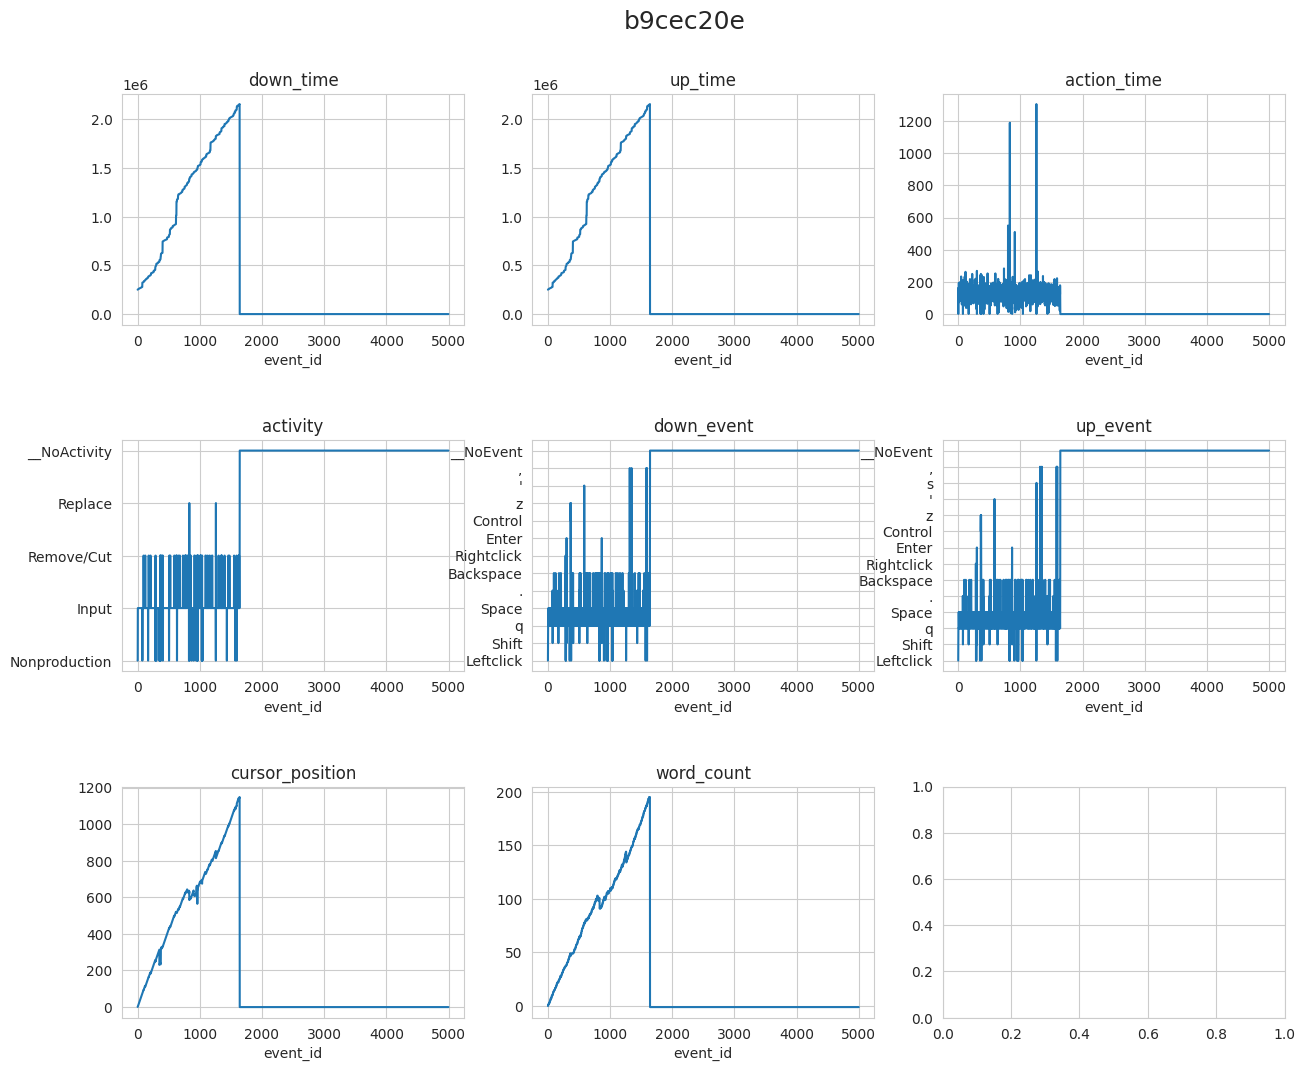

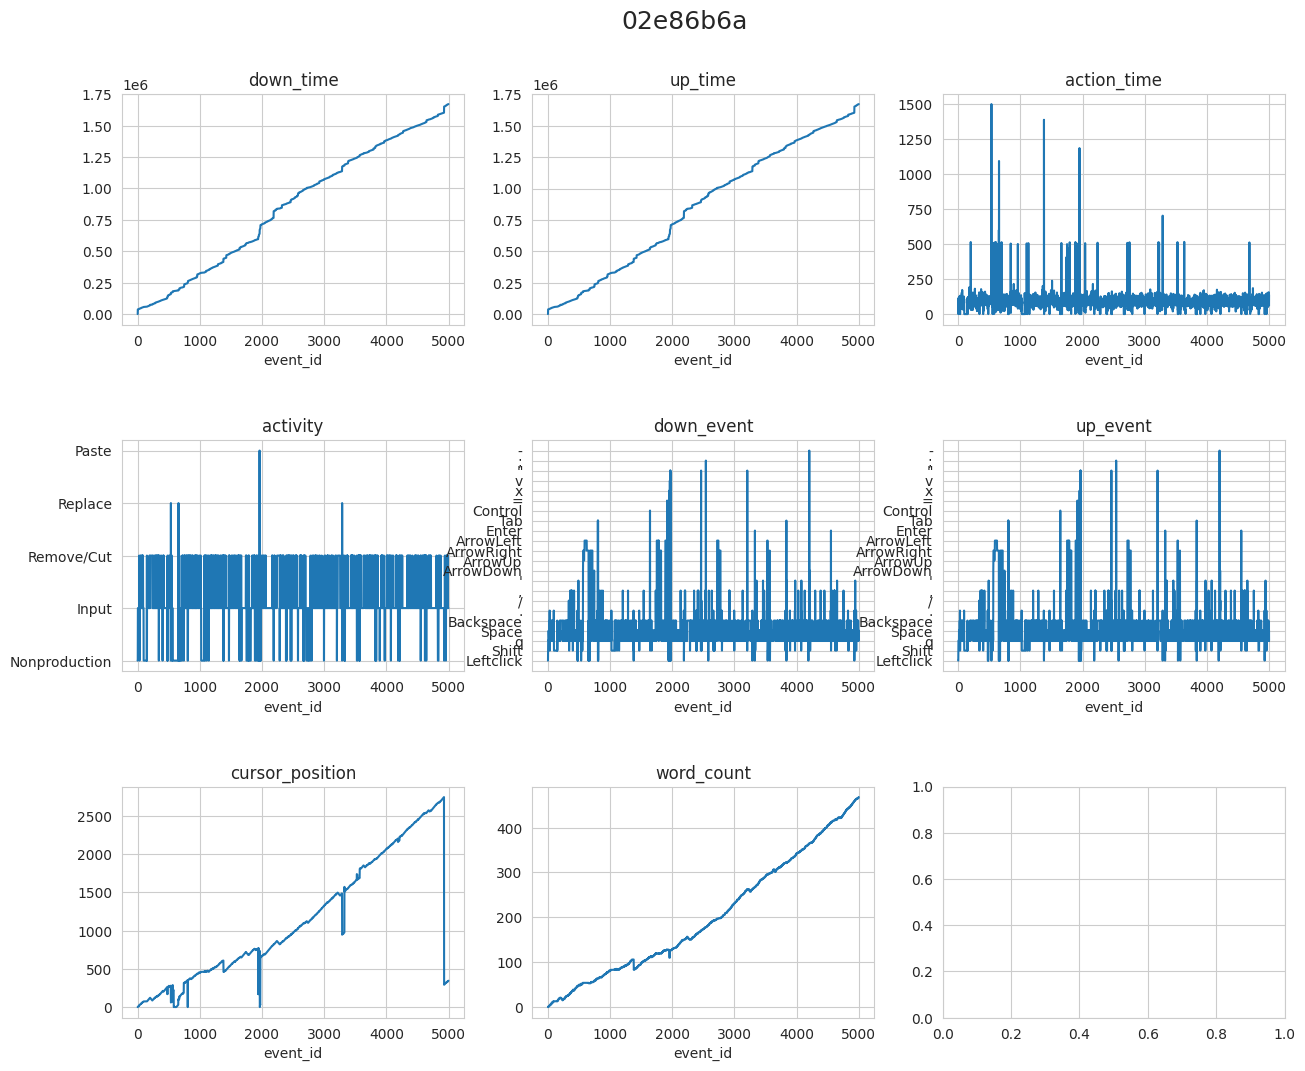

In [20]:
for i in range(2):
    sample = train_grpd_df.sample(1).iloc[0]
    plot_all_timeseries_events(sample)

In [21]:
calculated_clms = train_feats.drop(columns="id").columns.tolist()

### Model ###

#### DataLoader ####

In [22]:
class MultivariateTimeseriesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, calculated_clms, is_test=False):
        """
        Arguments:
        df: A grouped dataframe (sequences as list) and pre-processed to make each sequence of max sequence length
        is_test: Define whether it is a test set data loader.

        """
        self.df = df
        self.multivariate_clms = [
            "down_time",
            "up_time",
            "action_time",
            # "activity",
            # "down_event",
            # "up_event",
            # "text_change",
            "cursor_position",
            "word_count",
        ]
        self.calculated_clms = calculated_clms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        row_tensors = []
        for clm in self.multivariate_clms:
            tmp_tensor = torch.FloatTensor(row[clm]).reshape(-1, 1)
            row_tensors.append(tmp_tensor)

        final_tensor = torch.cat(row_tensors, 1)
        final_tensor = torch.as_tensor(final_tensor, dtype=torch.float32)

        calculated_tensor = torch.as_tensor(
            row[self.calculated_clms], dtype=torch.float32
        )
        if self.is_test:
            return final_tensor, calculated_tensor
        else:
            return (
                final_tensor,
                calculated_tensor,
                torch.as_tensor(row[CONFIG.response_variate], dtype=torch.float32),
            )

In [23]:
train_dataset = MultivariateTimeseriesDataset(
    train_grpd_df, calculated_clms, is_test=False
)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

In [24]:
dataloader_iterator = iter(train_dataloader)
# X, Y = next(dataloader_iterator)
X, X2, Y = next(dataloader_iterator)

In [25]:
X.shape

torch.Size([4, 5000, 5])

In [26]:
X2.shape

torch.Size([4, 197])

In [27]:
Y.reshape(-1, 1).shape

torch.Size([4, 1])

In [28]:
# tmp = torch.nn.Flatten(start_dim=1)(X)
# tmp = torch.cat([tmp,X2], dim=1)
# tmp.shape

In [29]:
Y

tensor([3.0000, 3.5000, 2.0000, 2.0000])

#### Model

In [30]:
hyper_params = {
    "encoder": {"hidden_size": 64, "num_layers": 2, 'dropout': 0.1},
    "enc_projection_head": {
        "num_layers": 3,
        "out_features_each_layer": [64, 128, 32],
        "dropout": 0.1,
    },
    "cal_feature_projection_head": {
        "num_layers": 2,
        "out_features_each_layer": [128, 128],
        "dropout": 0.1,
    },
    "regressor_head": {
        "num_layers": 4,
        "out_features_each_layer": [128,128,64,64],
        "dropout": 0.1,
    },
    "calculated_clms_len": len(calculated_clms),
}

In [31]:
class MultivariateTimeseriesRegression(torch.nn.Module):
    def __init__(self, seq_dim=0, seq_length=0,use_cal_features=True, hyper_params={}):
        super().__init__()

        self.seq_dim = seq_dim
        self.seq_length = seq_length
        self.use_cal_features = use_cal_features
        self.encoder = torch.nn.LSTM(
            input_size=seq_dim,
            hidden_size = hyper_params["encoder"]["hidden_size"] ,
            num_layers=hyper_params["encoder"]["num_layers"],
            dropout = hyper_params["encoder"]["dropout"],
            batch_first=True,
        )

        # PRojection Head
        modules = torch.nn.ModuleList()

        current_dim = hyper_params["encoder"]["hidden_size"]
        for i in range(hyper_params["enc_projection_head"]["num_layers"]):
            temp_block = torch.nn.Sequential(
                torch.nn.Linear(
                    current_dim,
                    hyper_params["enc_projection_head"]["out_features_each_layer"][i],
                ),
                torch.nn.BatchNorm1d(
                    num_features=hyper_params["enc_projection_head"][
                        "out_features_each_layer"
                    ][i]
                ),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=hyper_params["enc_projection_head"]["dropout"]),
            )
            modules.append(temp_block)
            current_dim = hyper_params["enc_projection_head"][
                "out_features_each_layer"
            ][i]
        self.enc_projection_head = torch.nn.Sequential(*modules)

        current_dim_enc = current_dim

        # Calculated features projection head
        if self.use_cal_features:
            modules = torch.nn.ModuleList()
            current_dim = hyper_params["calculated_clms_len"]
            for i in range(hyper_params["cal_feature_projection_head"]["num_layers"]):
                temp_block = torch.nn.Sequential(
                    torch.nn.Linear(
                        current_dim,
                        hyper_params["cal_feature_projection_head"][
                            "out_features_each_layer"
                        ][i],
                    ),
                    torch.nn.BatchNorm1d(
                        num_features=hyper_params["cal_feature_projection_head"][
                            "out_features_each_layer"
                        ][i]
                    ),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(p=hyper_params["regressor_head"]["dropout"]),
                )
                modules.append(temp_block)
                current_dim = hyper_params["cal_feature_projection_head"][
                    "out_features_each_layer"
                ][i]
    
            self.cal_feature_projection_head = torch.nn.Sequential(*modules)
            current_dim_cal = current_dim
        else:
            current_dim_cal = 0
            self.cal_feature_projection_head = None

        # Regression Head
        modules = torch.nn.ModuleList()
        current_dim = current_dim_enc + current_dim_cal
        for i in range(hyper_params["regressor_head"]["num_layers"]):
            temp_block = torch.nn.Sequential(
                torch.nn.Linear(
                    current_dim,
                    hyper_params["regressor_head"]["out_features_each_layer"][i],
                ),
                torch.nn.BatchNorm1d(
                    num_features=hyper_params["regressor_head"][
                        "out_features_each_layer"
                    ][i]
                ),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=hyper_params["regressor_head"]["dropout"]),
            )
            modules.append(temp_block)
            current_dim = hyper_params["regressor_head"]["out_features_each_layer"][i]

        final_layer = torch.nn.Sequential(
            torch.nn.Linear(current_dim, 1), torch.nn.ReLU()
        )
        modules.append(final_layer)
        self.regressor_head = torch.nn.Sequential(*modules)

    def forward(self, x, x2):
        encoding,_ = self.encoder(x)
        encoding = encoding[:,-1,:]
        encx = self.enc_projection_head(encoding)
        if self.use_cal_features:
            calx = self.cal_feature_projection_head(x2)
            finalx = torch.cat([encx, calx], dim=1)
        else:
            finalx = encx
        pred = self.regressor_head(finalx)
        return pred, encoding
        # return pred,[]

In [32]:
model_params = {}
model_params["seq_dim"] = 5
model_params["seq_length"] = CONFIG.max_timeseries_length
model_params["hyper_params"] = hyper_params
model_params['use_cal_features'] = False

In [33]:
model_params

{'seq_dim': 5,
 'seq_length': 5000,
 'hyper_params': {'encoder': {'hidden_size': 64,
   'num_layers': 2,
   'dropout': 0.1},
  'enc_projection_head': {'num_layers': 3,
   'out_features_each_layer': [64, 128, 32],
   'dropout': 0.1},
  'cal_feature_projection_head': {'num_layers': 2,
   'out_features_each_layer': [128, 128],
   'dropout': 0.1},
  'regressor_head': {'num_layers': 4,
   'out_features_each_layer': [128, 128, 64, 64],
   'dropout': 0.1},
  'calculated_clms_len': 197},
 'use_cal_features': False}

In [34]:
tmp_model = MultivariateTimeseriesRegression(**model_params)

In [35]:
tmp_model.enc_projection_head

Sequential(
  (0): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (2): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
)

In [36]:
tmp_model.cal_feature_projection_head

In [37]:
tmp_model.regressor_head

Sequential(
  (0): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (3): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (4): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=Tr

In [38]:
out,_ = tmp_model.encoder(X)

In [39]:
X.shape

torch.Size([4, 5000, 5])

In [40]:
out.shape

torch.Size([4, 5000, 64])

In [41]:
out, enc = tmp_model(X, X2)

In [42]:
out.shape

torch.Size([4, 1])

In [43]:
torch.cat([out, out]).flatten().shape

torch.Size([8])

In [44]:
enc.shape

torch.Size([4, 64])

### PL Trainer ###

In [45]:
# define the LightningModule
class LitMultiVariateTimeseries(pl.LightningModule):
    def __init__(self, all_params = {}):
        super().__init__()
        self.save_hyperparameters()
        
        model_params = all_params['model_params']
        self.model = MultivariateTimeseriesRegression(**model_params)
        self.training_params = all_params["training_params"]
        self.lr = training_params["lr"]

        # self.training_step_y_hat = []
        # self.training_step_y = []
        self.validation_step_y_hat = []
        self.validation_step_y = []

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, x2, y = batch
        y = y.reshape(-1, 1)
        pred, encoding = self.model(x, x2)
        loss = torch.nn.functional.mse_loss(pred, y)
        # Logging to TensorBoard (if installed) by default
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        # self.log("train_loss", loss)
        # self.training_step_y_hat.append(pred)
        # self.training_step_y.append(y)
        return loss

    # def on_train_epoch_end(self):
    #     all_preds = torch.cat(self.training_step_y_hat)
    #     all_y = torch.cat(self.training_step_y)
    #     all_preds = all_preds.flatten().detach().cpu()
    #     all_y = all_y.flatten().detach().cpu()
    #     # do something with all preds
    #     rmse = mean_squared_error(all_y, all_preds, squared=False)
    #     self.training_step_y_hat = []  # free memory
    #     self.training_step_y = []
    #     print(f"\t Epoch: {self.current_epoch}, RMSE Train: {rmse}")

    def validation_step(self, batch, batch_idx):
        loss, pred, y = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_loss": loss}
        self.log_dict(metrics)

        self.validation_step_y_hat.append(pred)
        self.validation_step_y.append(y)

        return metrics

    def on_validation_epoch_start(self):
        self.validation_step_y_hat = []  # free memory
        self.validation_step_y = []

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.validation_step_y_hat)
        all_y = torch.cat(self.validation_step_y)
        all_preds = all_preds.flatten().detach().cpu()
        all_y = all_y.flatten().detach().cpu()

        # do something with all preds
        rmse = mean_squared_error(all_y, all_preds, squared=False)
        metrics = {"val_rmse": rmse}
        self.log_dict(metrics)

        print(f"\t Epoch: {self.current_epoch}, RMSE Val: {rmse}")

    def _shared_eval_step(self, batch, batch_idx):
        x, x2, y = batch
        y = y.reshape(-1, 1)
        pred, encoding = self.model(x, x2)
        loss = torch.nn.functional.mse_loss(pred, y)
        return loss, pred, y

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, x2 = batch
        pred = self.model(x)
        return pred

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # return optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=10, factor=0.1,threshold = 1e-3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

In [46]:
train_df, val_df = train_test_split(
    train_grpd_df, test_size=CONFIG.test_size_optuna, random_state=42
)

In [47]:
train_df.shape, val_df.shape

((1976, 210), (495, 210))

In [48]:
train_dataset = MultivariateTimeseriesDataset(train_df, calculated_clms, is_test=False)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)

In [49]:
val_dataset = MultivariateTimeseriesDataset(val_df, calculated_clms, is_test=False)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=4)

In [50]:
training_params = {"lr": 1e-2, "early_stopping_patience": 15}

In [51]:
all_params = {}
all_params["model_params"] = model_params
all_params["training_params"] = training_params

In [52]:
all_params

{'model_params': {'seq_dim': 5,
  'seq_length': 5000,
  'hyper_params': {'encoder': {'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.1},
   'enc_projection_head': {'num_layers': 3,
    'out_features_each_layer': [64, 128, 32],
    'dropout': 0.1},
   'cal_feature_projection_head': {'num_layers': 2,
    'out_features_each_layer': [128, 128],
    'dropout': 0.1},
   'regressor_head': {'num_layers': 4,
    'out_features_each_layer': [128, 128, 64, 64],
    'dropout': 0.1},
   'calculated_clms_len': 197},
  'use_cal_features': False},
 'training_params': {'lr': 0.01, 'early_stopping_patience': 15}}

In [53]:
task = LitMultiVariateTimeseries(all_params = all_params)

In [54]:
checkpoint_callback = ModelCheckpoint(
    # dirpath=f"{CONFIG.training_logs_path}/{CONFIG.experiment_name}/",
    monitor="val_rmse",
    filename="{epoch}-{val_rmse:.4f}",
    every_n_train_steps=1,
    mode="min",
    save_top_k=1,
)

In [55]:
# tb_logger = pl_loggers.TensorBoardLogger(
#     save_dir=f"training_logs/{CONFIG.experiment_name}"
# )

In [56]:
# progress_bar = RichProgressBar(
#     theme=RichProgressBarTheme(
#         description="green_yellow",
#         progress_bar="green1",
#         progress_bar_finished="green1",
#         progress_bar_pulse="#6206E0",
#         batch_progress="green_yellow",
#         time="grey82",
#         processing_speed="grey82",
#         metrics="grey82",
#         metrics_text_delimiter="\n",
#         metrics_format=".3e",
#     )
# )
trainer = pl.Trainer(
    accelerator="gpu",
    default_root_dir=f"{CONFIG.training_logs_path}/{CONFIG.experiment_name}/",
    callbacks=[
        EarlyStopping(
            monitor="val_rmse",
            mode="min",
            patience=training_params["early_stopping_patience"],
        ),
        RichProgressBar(),
        checkpoint_callback,
        # progress_bar,
    ],
    max_epochs=100,
    # enable_progress_bar=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [57]:
# from lightning.pytorch.tuner.tuning import Tuner
# lr_finder = Tuner(trainer).lr_find(model = task,train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,min_lr=1e-04, max_lr=1, num_training=1000)

In [58]:
trainer.fit(task, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type                             ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ MultivariateTimeseriesRegression │  102 K │
└───┴───────┴──────────────────────────────────┴────────┘

Trainable params: 102 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 102 K                                                                                                
Total estimated model params size (MB): 0

Epoch: 0, RMSE Val: 3.7538557052612305

Epoch: 0, RMSE Val: 0.9750386476516724

Epoch: 1, RMSE Val: 0.9091795086860657

Epoch: 2, RMSE Val: 0.9575681686401367

Epoch: 3, RMSE Val: 0.9883446097373962

Epoch: 4, RMSE Val: 0.9525465369224548

Epoch: 5, RMSE Val: 0.907209038734436

Epoch: 6, RMSE Val: 0.9117459058761597

Epoch: 7, RMSE Val: 0.9127873778343201

Epoch: 8, RMSE Val: 0.9568473100662231

Epoch: 9, RMSE Val: 0.913152813911438

Epoch: 10, RMSE Val: 0.9349215626716614

Epoch: 11, RMSE Val: 0.9722987413406372

Epoch: 12, RMSE Val: 0.9078362584114075

Epoch: 13, RMSE Val: 0.9630870819091797

Epoch: 14, RMSE Val: 0.9486234784126282

Epoch: 15, RMSE Val: 1.0219581127166748

Epoch: 16, RMSE Val: 0.9215520024299622

Epoch: 17, RMSE Val: 0.92823725938797

Epoch: 18, RMSE Val: 0.9170727133750916

Epoch: 19, RMSE Val: 0.9101553559303284

Epoch: 20, RMSE Val: 0.9130693078041077

In [59]:
print(task)

LitMultiVariateTimeseries(
  (model): MultivariateTimeseriesRegression(
    (encoder): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.1)
    (enc_projection_head): Sequential(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=128, out_features=32, bias=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (regressor_head): Sequential(
      (0): Sequential

### Tuning 

### Validation

In [60]:
# new_model = LitMultiVariateTimeseries.load_from_checkpoint("training_logs/Transformer/lightning_logs/version_5/checkpoints/epoch=65-val_rmse=0.7366.ckpt")

In [61]:
# pl.Trainer().validate(model = new_model, dataloaders= val_dataloader)

### Prediction